In [1]:
import sys
sys.path.append('./utils/')
import numpy as np
import scipy.io as spio
from scipy.linalg import expm
from matplotlib import pyplot as plt
import sys
sys.path.append('./utils/')

from basis_utils import read_spinach_info, build_list_ISTs, NormalizeBasis, MatRepLib,Sz
from analytical_fit import GetRelManySpins

#from simulation_utils import EmbedInU,run_simp_layer_flow_example, SimulateBlock,EstimatePolarization


In [2]:
#Auxiliary function to perform the apodization of FID
def sqcosbell_2d_apod(fid_2d):
    fid_2d[0,:] = fid_2d[0,:]/2
    fid_2d[:,0] = fid_2d[:,0]/2
    x = np.linspace(0,np.pi/2,fid_2d.shape[0])
    y = np.linspace(0,np.pi/2,fid_2d.shape[1])

    decay_col = np.square(np.cos(x))
    decay_row = np.square(np.cos(y))

    return fid_2d*np.outer(decay_col,decay_row)


In [3]:
####These are the Spinach-generated inputs needed for the analytical generation of relaxation matrix...
text="""1      (0,0)   (0,0)   
  2      (0,0)   (1,1)   
  3      (0,0)   (1,0)   
  4      (0,0)   (1,-1)  
  5      (1,1)   (0,0)   
  6      (1,1)   (1,1)   
  7      (1,1)   (1,0)   
  8      (1,1)   (1,-1)  
  9      (1,0)   (0,0)   
  10     (1,0)   (1,1)   
  11     (1,0)   (1,0)   
  12     (1,0)   (1,-1)  
  13     (1,-1)  (0,0)   
  14     (1,-1)  (1,1)   
  15     (1,-1)  (1,0)   
  16     (1,-1)  (1,-1)  
"""
gammaF = 251814800
coord1 = np.array([-0.0551,-1.2087,-1.6523])*1e-10
coord2 = np.array([-0.8604 ,-2.3200 ,-0.0624])*1e-10

coords = np.array([coord1,coord2])

w1 = -376417768.6316 
w2 = -376411775.1523 
freqs = np.array([w1,w2])
tc = 0.5255e-9

data = read_spinach_info(text)

basis = build_list_ISTs(data)

Normbasis = NormalizeBasis(basis,n_qubits=2,checkOrth=True)


K2,K1,K0,R_analytical = GetRelManySpins(2*np.pi*freqs,coords,tc,gammaF,Normbasis)

#We add the T2 relaxation with the parameter taken from Spinach script...
t2_rel=34.0359

R_analytical+=2*t2_rel*MatRepLib(Normbasis,Sz(0),Sz(0))
R_analytical+=2*t2_rel*MatRepLib(Normbasis,Sz(1),Sz(1))



K2 type contributions finished
K1 type contributions finished
K0 type contributions finished


In [5]:
def GenNOESYSpectrum(Ham,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly):
    
    #Dim = Ham.shape[0]
    Lnet = Ham+1j*R 
    L_dt1 = expm(-1j*Lnet*dt1)
    L_dt2 = expm(-1j*Lnet*dt2)
    pulse_mix = expm(-1j*Lnet*tmix)


    pulse_90x = expm(-1j*Lx*np.pi/2)
    pulse_90y = expm(-1j*Ly*np.pi/2)
    pulse_90mx = expm(1j*Lx*np.pi/2)
    pulse_90my = expm(1j*Ly*np.pi/2)


    FID_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
    FID_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
    FID_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
    FID_4 = np.zeros([Tpts2,Tpts1],dtype=complex)

    #First 90x pulse:
    rho_t = np.copy(rho0)
    rho_t = np.dot(pulse_90x,rho_t)

    rho_stack = []
    rho_stack.append(rho_t)

    rho_temp = np.copy(rho_t)
    for i in range(1,Tpts1):
        rho_temp = np.dot(L_dt1,rho_temp)
        rho_stack.append(rho_temp)


    rho_stack1_1 = []
    rho_stack1_2 = []
    rho_stack1_3 = []
    rho_stack1_4 = []

    for i in range(Tpts1):
        rho_stack1_1.append(pulse_90y@pulse_mix@pulse_90x@rho_stack[i])
        rho_stack1_2.append(pulse_90y@pulse_mix@pulse_90y@rho_stack[i])
        rho_stack1_3.append(pulse_90y@pulse_mix@pulse_90mx@rho_stack[i])
        rho_stack1_4.append(pulse_90y@pulse_mix@pulse_90my@rho_stack[i])


    fid_temp_1 = np.zeros([Tpts2,Tpts1],dtype=complex)
    fid_temp_2 = np.zeros([Tpts2,Tpts1],dtype=complex)
    fid_temp_3 = np.zeros([Tpts2,Tpts1],dtype=complex)
    fid_temp_4 = np.zeros([Tpts2,Tpts1],dtype=complex)

    for i in range(Tpts1):
        rho1 = rho_stack1_1[i]
        rho2 = rho_stack1_2[i]
        rho3 = rho_stack1_3[i]
        rho4 = rho_stack1_4[i]

        for j in range(Tpts2):
            fid_temp_1[j,i] = np.dot(coil,rho1)
            rho1 = L_dt2@rho1

            fid_temp_2[j,i] = np.dot(coil,rho2)
            rho2 = L_dt2@rho2

            fid_temp_3[j,i] = np.dot(coil,rho3)
            rho3 = L_dt2@rho3

            fid_temp_4[j,i] = np.dot(coil,rho4)
            rho4 = L_dt2@rho4

    fid_test_cos = fid_temp_1 - fid_temp_3
    fid_test_sin = fid_temp_2 - fid_temp_4

    fid_cos = sqcosbell_2d_apod(fid_test_cos)
    fid_sin = sqcosbell_2d_apod(fid_test_sin)

    f1_cos = np.real(np.fft.fftshift(np.fft.fft2(fid_cos,[zerofill2],[0]),[0]))
    f1_sin = np.real(np.fft.fftshift(np.fft.fft2(fid_sin,[zerofill2],[0]),[0]))


    f1_states = f1_cos-1j*f1_sin

    spectrum = np.fft.fftshift(np.fft.fft2(f1_states,[zerofill1],[1]),[1])

    return spectrum

    




In [6]:
###Loading the generator of evolution...
loadMat = spio.loadmat('./data/DFG.mat',squeeze_me=True)

AuxMats = spio.loadmat('./data/DFG_NOESYmatrices.mat',squeeze_me=True)


Ham = loadMat['p']['H'].item()
R = loadMat['p']['R'].item()
t_grid1 = loadMat['p']['time_grid1'].item()
t_grid2 = loadMat['p']['time_grid2'].item()

###Dynamical evolution for calculation of 2D spectra...
##TODO: we can simply modify the script to incorporate 1) retrieval of synthesized circuits,
#and 2) the already-developed circuit simulator

Tpts1 = len(t_grid1)
Tpts2 = len(t_grid2)

Dim = Ham.shape[0]

rho0 = np.array(AuxMats['rho0'].toarray())
rho0 = rho0.flatten()
coil = AuxMats['coil']


tmix = 0.5
dt1 = 1.1561e-04
dt2 = 1.1561e-04

##Parameters for Fourier transform
zerofill1 = 1024
zerofill2 = 1024

##Definition of pulses in the experiment...
#This also depends on the definition of the basis....
Lx = AuxMats['Lx'].toarray()
Ly = AuxMats['Ly'].toarray()


Spectrum = GenNOESYSpectrum(Ham,R,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)

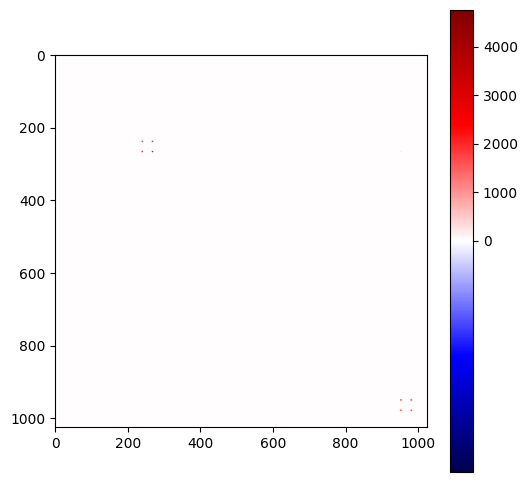

In [9]:
#There is some plotting pre-processing of the NMR spectrum that we are ignoring here, that is why
#we get a different plot that the one produced in the matlab script
from matplotlib.colors import TwoSlopeNorm

norm = TwoSlopeNorm(vmin=-np.min(-np.real(Spectrum)), vcenter=0, vmax=np.max(-np.real(Spectrum)))

plt.figure(figsize=(6, 6))
plt.imshow(-np.real(Spectrum), cmap='seismic',norm=norm)
plt.colorbar()
plt.show()

In [13]:
#Frobenius norm of the difference between the Spinach relaxation matrix and the one generated analytically...

np.linalg.norm(R_analytical-R)


0.007288837876891098

In [10]:
#We can repeat the same calculation substituting Spinach-generated relaxation matrix with that generated analytically...

Spec_from_GenR = GenNOESYSpectrum(Ham,R_analytical,Tpts1,Tpts2,rho0,coil,tmix,dt1,dt2,zerofill1,zerofill2,Lx,Ly)



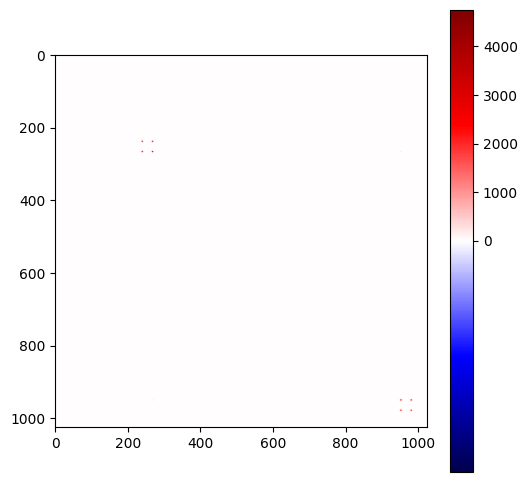

In [11]:
norm = TwoSlopeNorm(vmin=-np.min(-np.real(Spec_from_GenR)), vcenter=0, vmax=np.max(-np.real(Spec_from_GenR)))

plt.figure(figsize=(6, 6))
plt.imshow(-np.real(Spec_from_GenR), cmap='seismic',norm=norm)
plt.colorbar()
plt.show()

In [12]:
#Frobenius norm of the difference of spectra generated starting from Spinach-generated relaxation matrix and analytically
np.linalg.norm(Spectrum-Spec_from_GenR)

7.4165925367012875